<h1> GAN - CNN</h1>

Dieses Notebook basiert auf "1_intoduce-GAN-ANN". Diesmal wird ein CNN Netz angewendet, um die Qualität zu steigern.

<i>Abb1</i>: Übersicht GAN.

<img src="./data/img/2_gan.PNG" height=500 width=700>

Als Erstes werden wir wieder nur eine Klasse nutzen und versuchen mit einem Generator basierend auf CNN ein Bild zu erzeugen.

Als Einstieg soll der Generator ein 256*256 Pixelbild eines Apfels herstellen. 

In [2]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Hier werden wir die Funktionsweise des Faltungsnetzes umkehren. Zu Beginn geben wir die Dimension des Bildes an, das dann Hochskaliert wird.

>tf.keras.layers.Conv2DTranspose:<br>
>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose [Letzter Zugriff: 23.07.2024]

<h2>Aufbau Netz</h2>

In [94]:
image_dim = 256 * 256
noise_dim = 125

In [108]:
# Generator soll Bild erzeugen.
def create_generator(img_dim:int=125):
    model = tf.keras.Sequential()
    # ---- # 
    model.add(tf.keras.layers.Dense(units=8*8*256, input_shape=(img_dim, ), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 8, 8, 256)))  # Model Output: (1, 8, 8, 256)
    # ---- # 
    # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 8, 8, 256)
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))  # Durch Strides, Filters und Padding wird Output skaliert.
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 16, 16, 64)
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 32, 32, 32)
    # Transpose # 4
    model.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 64, 64, 16)
    # Transpose # 5
    model.add(tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  
    # Transpose 6
    model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Anders als bei einem ANN muss der Output nicht extra 

    return model
    

Beim Konstruieren kann so z. B. der Output und die Form eingesehen und weitere Informationen ausgegeben werden.

Der Aufbau hier ist wieder recht simpel, wenn es darum geht nur eine Klasse eines Bildes zu erzeugen.

In [112]:
noise = np.random.normal(0, 1, (1, 125))  
generator = create_generator(noise_dim)
img = generator(noise)
img.shape

TensorShape([1, 256, 256, 1])

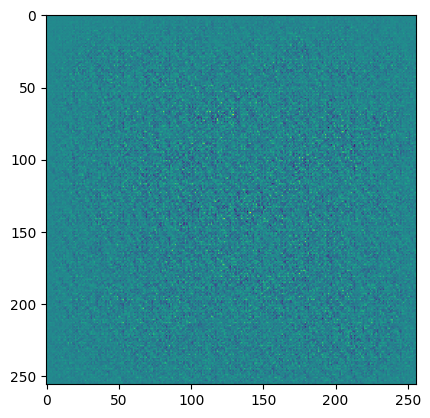

In [113]:
plt.imshow(img[0])

Jetzt kommt der Discriminator.

In [114]:
def create_discriminator():
    model = tf.keras.Sequential()
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    return model
    

<h2>Training 1</h2>

Danach erstellen wir das GAN-Netzwerk und trainieren es.

In [115]:
def create_GAN(gen, disc):
    # Kombiniere.
    gan_input   = tf.keras.layers.Input(shape=(125,))  
    gen_output = generator(gan_input)

    disc_output = discriminator(gen_output)
    GAN         = tf.keras.Model(gan_input, disc_output)

    GAN.compile(optimizer='adam', loss='binary_crossentropy')

In [116]:
# Erstelle Modelle. 
generator     = create_generator()
discriminator = create_discriminator()

In [ ]:
# Kompiliere Modelle.

<h2>Training 2</h2>